# American Put Option Valuation using Binomial Tree

In [ ]:
# American Put Option Valuation using Binomial Tree
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings("ignore", category=UserWarning)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Pulling close price as at 16 May 2025 from yfinance
ticker = "CBA.AX"
valuation_date = datetime(2025, 5, 16)
expiry_date = datetime(2026, 5, 15)
target_date_str = valuation_date.strftime("%Y-%m-%d")
data = yf.download(ticker, start=target_date_str, end="2026-05-17", progress=False)
if data.empty:
    raise ValueError(f"No data available for {ticker} on {target_date_str}")
S0 = float(data["Close"].iloc[0])  # Ensure scalar

# Calculate time to maturity dynamically 
T = (expiry_date - valuation_date).days / 365.25  # Year fraction


# Pull volatility (sigma) from cell R12 in sheet "Worksheet"
vol_file = "Rates_Volatilities.xlsx"
from openpyxl import load_workbook

# Open the workbook and access the value from R12
wb = load_workbook(filename=vol_file, data_only=True)
ws = wb["CBA"]
sigma = ws["Q11"].value  # This returns the evaluated result (not the formula)

if sigma is None:
    raise ValueError("Volatility (sigma) in cell Q11 returned None — please check if Excel formula has been calculated and saved.")

wb.close()

/tmp/ipykernel_37341/510970469.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(data["Close"].iloc[0])  # Ensure scalar


In [8]:
# Option parameters
K = 170.00
T = 1.0
r = 0.04
N = 3
print(f"Inputs:\nSpot = {S0:.2f}, Strike = {K}, Time = {T}, Rate = {r}, Volatility = {sigma:.2%}")

Inputs:
Spot = 169.66, Strike = 170.0, Time = 1.0, Rate = 0.04, Volatility = 22.93%



American Put Option Value: $13.97


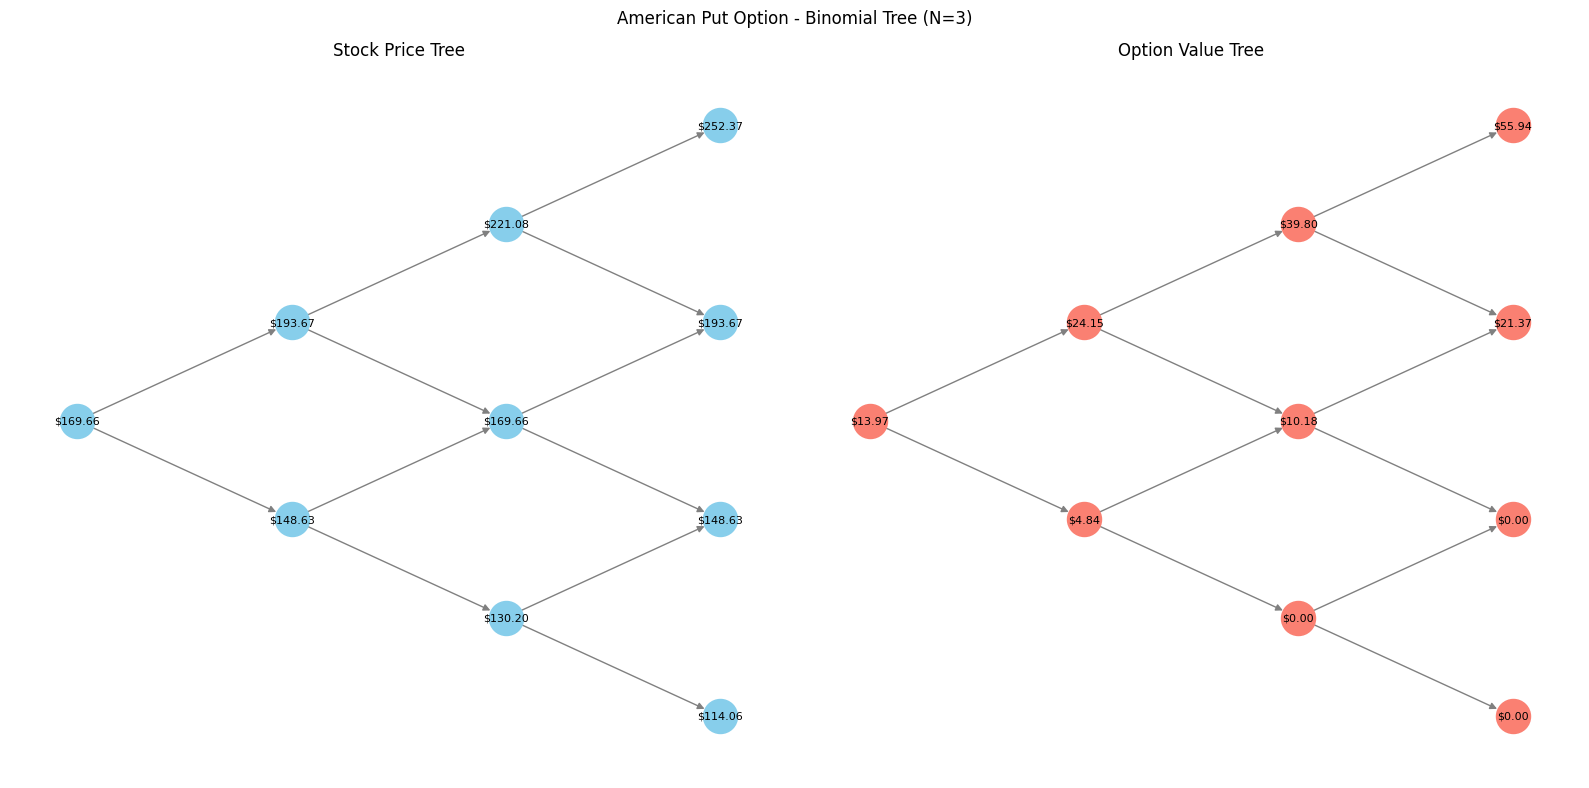

In [9]:
from instrument_classes import AmericanPut

# Instantiate and price the option
put_option = AmericanPut(S0=S0, K=170.0, T=T, r=0.04, sigma=sigma, N=3)
price = put_option.price()

print(f"\nAmerican Put Option Value: ${price:.2f}")
put_option.visualize()